In [11]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import re
import logging
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.base import BaseEstimator, TransformerMixin
from transformers import RobertaTokenizer
from transformers import RobertaForSequenceClassification, Trainer, TrainingArguments

In [12]:
cleaned_data = pd.read_pickle('../notebooks/cleaned_data.pkl')
cleaned_data

,review,sentiment,cleaned_review
0,One of the other reviewers has mentioned that ...,positive,one reviewer mentioned watching oz episode hoo...
1,A wonderful little production. <br /><br />The...,positive,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,negative,basically family little boy jake think zombie ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter mattei love time money visually stunnin...
...,...,...,...
49995,I thought this movie did a down right good job...,positive,thought movie right good job creative original...
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,bad plot bad dialogue bad acting idiotic direc...
49997,I am a Catholic taught in parochial elementary...,negative,catholic taught parochial elementary school nu...
49998,I'm going to have to disagree with the previou...,negative,going disagree previous comment side maltin on...


In [14]:
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, log_every=1000):
        self.log_every = log_every

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return np.array([
            self._preprocess(text, idx) for idx, text in enumerate(X)
        ])

    def _preprocess(self, text, idx=None):
        if idx is not None and self.log_every and idx % self.log_every == 0:
            logging.info(f"Preprocessing row {idx}")

        # Remove HTML tags
        text = re.sub(r"<.*?>", " ", text)
        # Lowercase only (keep punctuation)
        text = text.lower()
        return text

In [15]:
preprocessor = TextPreprocessor()
review_copy = cleaned_data['review'].copy()
cleaned_reviews = preprocessor.transform(review_copy)

cleaned_data['cleaned_review_roberta'] = cleaned_reviews
cleaned_data

,review,sentiment,cleaned_review,cleaned_review_roberta
0,One of the other reviewers has mentioned that ...,positive,one reviewer mentioned watching oz episode hoo...,one of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,positive,wonderful little production filming technique ...,a wonderful little production. the filming t...
2,I thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...,i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,negative,basically family little boy jake think zombie ...,basically there's a family where a little boy ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter mattei love time money visually stunnin...,"petter mattei's ""love in the time of money"" is..."
...,...,...,...,...
49995,I thought this movie did a down right good job...,positive,thought movie right good job creative original...,i thought this movie did a down right good job...
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,bad plot bad dialogue bad acting idiotic direc...,"bad plot, bad dialogue, bad acting, idiotic di..."
49997,I am a Catholic taught in parochial elementary...,negative,catholic taught parochial elementary school nu...,i am a catholic taught in parochial elementary...
49998,I'm going to have to disagree with the previou...,negative,going disagree previous comment side maltin on...,i'm going to have to disagree with the previou...


In [16]:
cleaned_data['label'] = cleaned_data['sentiment'].map({'positive': 1, 'negative': 0})
cleaned_data

,review,sentiment,cleaned_review,cleaned_review_roberta,label
0,One of the other reviewers has mentioned that ...,positive,one reviewer mentioned watching oz episode hoo...,one of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,positive,wonderful little production filming technique ...,a wonderful little production. the filming t...,1
2,I thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...,i thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,negative,basically family little boy jake think zombie ...,basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter mattei love time money visually stunnin...,"petter mattei's ""love in the time of money"" is...",1
...,...,...,...,...,...
49995,I thought this movie did a down right good job...,positive,thought movie right good job creative original...,i thought this movie did a down right good job...,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,bad plot bad dialogue bad acting idiotic direc...,"bad plot, bad dialogue, bad acting, idiotic di...",0
49997,I am a Catholic taught in parochial elementary...,negative,catholic taught parochial elementary school nu...,i am a catholic taught in parochial elementary...,0
49998,I'm going to have to disagree with the previou...,negative,going disagree previous comment side maltin on...,i'm going to have to disagree with the previou...,0


In [19]:
print(cleaned_data['label'].isnull().sum())

0


In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    cleaned_data['cleaned_review_roberta'], cleaned_data['label'], test_size=0.2, random_state=42
)

train_df = pd.DataFrame({'text': X_train, 'label': y_train}).reset_index(drop=True)
test_df = pd.DataFrame({'text': X_test, 'label': y_test}).reset_index(drop=True)

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

In [20]:
print(test_df['label'].value_counts())

label
1    4978
0    4939
Name: count, dtype: int64


In [21]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

def tokenize_function(batch):
    return tokenizer(batch['text'], padding='max_length', truncation=True, max_length=128)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

Map:   0%|          | 0/39665 [00:00<?, ? examples/s]

Map:   0%|          | 0/9917 [00:00<?, ? examples/s]

In [ ]:
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir='./logs',
    logging_steps=10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\aarsh\OneDrive\Desktop\Projects\Review-sentiment-analysis\venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy
1,0.698800,0.693151,0.498034
2,0.691300,0.693312,0.501966


c:\Users\aarsh\OneDrive\Desktop\Projects\Review-sentiment-analysis\venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\aarsh\OneDrive\Desktop\Projects\Review-sentiment-analysis\venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Accuracy: 0.5019663204598165


In [22]:
results = trainer.evaluate()
print("Accuracy:", results["eval_accuracy"])

c:\Users\aarsh\OneDrive\Desktop\Projects\Review-sentiment-analysis\venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Accuracy: 0.5019663204598165


In [9]:
model.save_pretrained('../models/roberta_sentiment')
tokenizer.save_pretrained('../models/roberta_sentiment')

('../models/roberta_sentiment\\tokenizer_config.json',
 '../models/roberta_sentiment\\special_tokens_map.json',
 '../models/roberta_sentiment\\vocab.json',
 '../models/roberta_sentiment\\merges.txt',
 '../models/roberta_sentiment\\added_tokens.json')

Accuracy: 0.5019663204598165


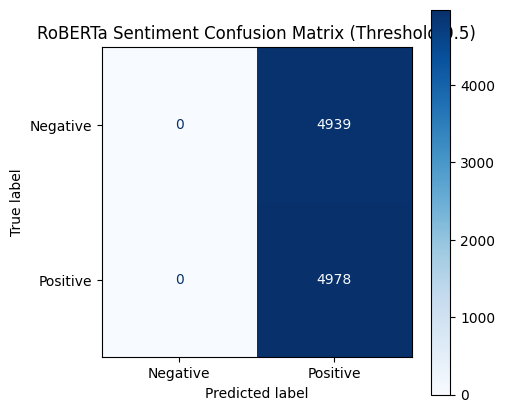

In [25]:
# Get predictions on the test set
predictions = trainer.predict(test_dataset)
y_true = predictions.label_ids

# Get probability for positive class (class 1)
probs = torch.softmax(torch.tensor(predictions.predictions), dim=1)[:, 1].numpy()

# Classify as positive if prob > 0.5, else negative
y_pred = (probs > 0.5).astype(int)

# Now you can compute accuracy and confusion matrix as before
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

print("Accuracy:", accuracy_score(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred)
labels = ["Negative", "Positive"]

fig, ax = plt.subplots(figsize=(5, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=True)
plt.title("RoBERTa Sentiment Confusion Matrix (Threshold 0.5)")
plt.show()

In [27]:
for i in range(10):
    print("Text:", test_df.iloc[i]['text'])
    print("True label:", test_df.iloc[i]['label'])
    print("Predicted:", y_pred[i])
    print("---")

Text: "soul plane" is a horrible attempt at comedy that only should appeal people with thick skulls, bloodshot eyes and furry pawns.   the plot is not only incoherent but also non-existent, acting is mostly sub sub-par with a gang of highly moronic and dreadful characters thrown in for bad measure, jokes are often spotted miles ahead and almost never even a bit amusing. this movie lacks any structure and is full of racial stereotypes that must have seemed old even in the fifties, the only thing it really has going for it is some pretty ladies, but really, if you want that you can rent something from the "adult" section. ok?  i can hardly see anything here to recommend since you'll probably have a lot a better and productive time chasing rats with a sledgehammer or inventing waterproof teabags or whatever.  2/10
True label: 0
Predicted: 1
---
Text: guest from the future tells a fascinating story of time travel, friendship, battle of good and evil -- all with a small budget, child actors